In [5]:
import itertools
import os
from pathlib import Path
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

import shelve
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata

from matplotlib import pyplot
from toolz import keyfilter

from formatting import h2, format_ci, format_decimal, render_struct_table
from notebooks.heart_transplant.heart_transplant_training_curves import \
    HEART_TRANSPLANT_TRAINING_CURVES_EXPANDING_IDENTIFIER
from utils import transpose_list, transpose_dicts
from visualisation import set_integer_ticks, display_html, savefig

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from notebooks.heart_transplant.dependencies.heart_transplant_functions import format_heart_transplant_method_name, \
    format_feature

from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached

pyplot.style.use('default')

FIGURE_FOLDER  = './data/heart_transplant/figures'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)


[Memory]0.3s, 0.0min    : Loading get_reduced_binary_dataset...
[Memory]1.2s, 0.0min    : Loading get_reduced_binary_dataset...
[Memory]2.8s, 0.0min    : Loading get_reduced_binary_dataset...
[Memory]3.8s, 0.1min    : Loading get_reduced_binary_dataset...


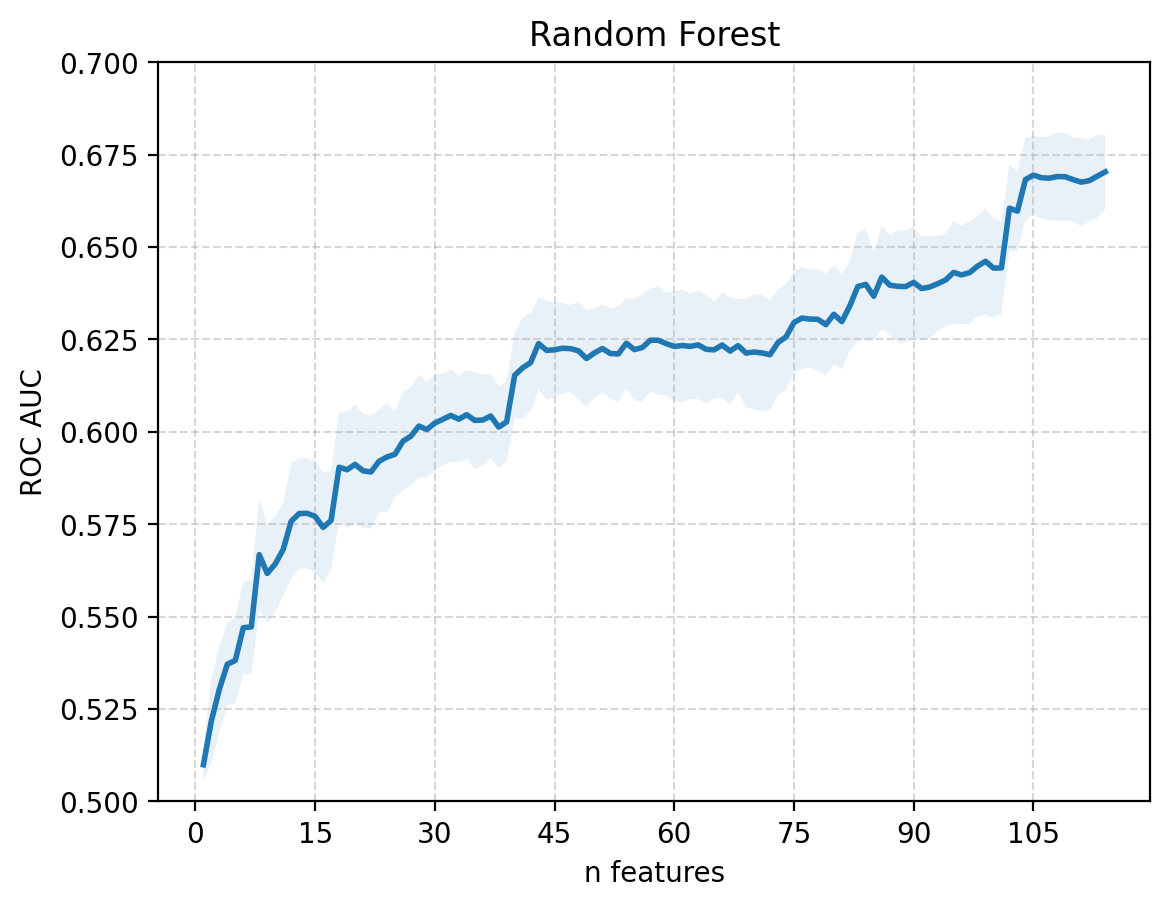

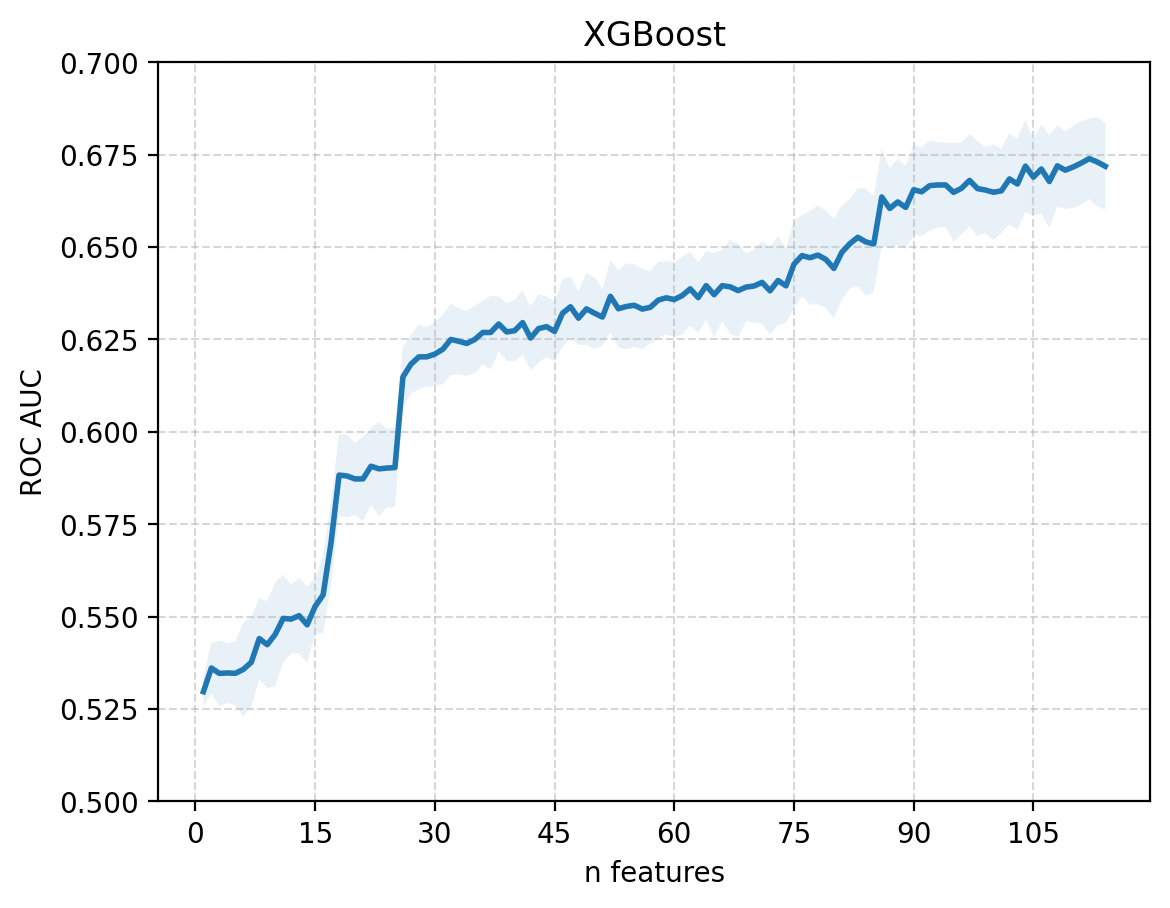

In [10]:
with shelve.open(HEART_TRANSPLANT_TRAINING_CURVES_EXPANDING_IDENTIFIER+'_365_ALL', 'ru') as data:

    def plot_x_y(_metrics, **kwargs):
        x_auc, y_auc = transpose_list([
            [_n_features, _metrics[_n_features]['roc_auc'].mean]
            for _n_features in sorted(list(_metrics.keys()))
        ])

        x_confidence, y_low_confidence, y_high_confidence = transpose_list([
            [_n_features, *_metrics[_n_features]['roc_auc'].ci]
            for _n_features in sorted(list(_metrics.keys()))
        ])

        pyplot.plot(x_auc, y_auc, lw=2, **kwargs)
        pyplot.fill_between(x_confidence, y_low_confidence, y_high_confidence, alpha=0.1)

    for method_name, item in data.items():
       pyplot.figure()
       pyplot.grid(alpha=0.5, linestyle='--', linewidth=0.75)
       pyplot.title(format_heart_transplant_method_name(method_name))
       for score_type, metrics_item in keyfilter(lambda k: k in ('test',), transpose_dicts(item)).items():
            plot_x_y(metrics_item, label=score_type)
            pyplot.xlabel('n features')
            pyplot.ylabel('ROC AUC')
            pyplot.ylim(0.5, 0.7)
       set_integer_ticks()
       savefig(FIGURE_FOLDER+f'/training_curves/{method_name}.svg')


In [8]:
with shelve.open(HEART_TRANSPLANT_TRAINING_CURVES_EXPANDING_IDENTIFIER+'_365_ALL', 'ru') as data:
    for method_name, series in data.items():
        h2(format_heart_transplant_method_name(method_name))

        rows = []
        last_item = None
        rows.append(['<b>n features</b>', '<b>ROC AUC</b>', '<b>CI</b>', '<b>feature</b>'])
        for n_features, item in sorted(series.items(), key=lambda i: i[0]):
            # print()
            current_features = set(item['features'])

            if last_item:
                added_feature = (current_features-set(last_item['features'])).pop()
                rows.append([n_features, format_decimal(last_item['test']['roc_auc'].mean) + ' + ' + format_decimal(item['test']['roc_auc'].mean-last_item['test']['roc_auc'].mean), format_ci(item['test']['roc_auc'].ci), '+ '+ format_feature(metadata, added_feature)])
            else:
                rows.append([n_features, format_decimal(item['test']['roc_auc'].mean), format_ci(item['test']['roc_auc'].ci), '+ '+(",".join(current_features))])
            last_item = item
        display_html(render_struct_table(rows))

n features,ROC AUC,CI,feature
1,0.51,0.506—0.514,+ ecd_donor
2,0.51 + 0.012,0.511—0.533,+ Education
3,0.522 + 0.009,0.519—0.542,+ Angiogram in donor
4,0.53 + 0.007,0.526—0.548,+ Other drug use in last 6 months—Donor
5,0.537 + 0.001,0.526—0.55,+ History of cancer donor
6,0.538 + 0.009,0.535—0.559,+ Retransplant indiciation
7,0.547 + 0.0,0.534—0.56,+ Prior cardiac surgery recipient type
8,0.547 + 0.02,0.552—0.582,+ Thoracic diagnosis
9,0.567 + -0.005,0.548—0.575,+ Blood group
10,0.562 + 0.003,0.551—0.577,+ History of alcohol in donor


n features,ROC AUC,CI,feature
1,0.53,0.526—0.534,+ dial_prior_tx
2,0.53 + 0.006,0.529—0.543,+ History of cigarettes use donor
3,0.536 + -0.001,0.526—0.543,+ Heavy alcohol use donor
4,0.535 + 0.0,0.527—0.543,+ Intracranial cancer donor
5,0.535 + 0.0,0.526—0.543,+ Blood urea nitrogen donor (log)
6,0.535 + 0.001,0.523—0.548,+ Donor weight (log)
7,0.536 + 0.002,0.526—0.55,+ CMV IgG
8,0.538 + 0.006,0.533—0.555,+ Calculated BMI donor
9,0.544 + -0.002,0.531—0.554,+ Cerebrovascular disease
10,0.542 + 0.003,0.531—0.559,+ Mean pulmonary pressure recipient (mmHg)


n features,ROC AUC,CI,feature
1,0.51,0.506—0.514,+ ecd_donor
2,0.51 + 0.012,0.511—0.533,+ Education
3,0.522 + 0.009,0.519—0.542,+ Angiogram in donor
4,0.53 + 0.007,0.526—0.548,+ Other drug use in last 6 months—Donor
5,0.537 + 0.001,0.526—0.55,+ History of cancer donor
6,0.538 + 0.009,0.535—0.559,+ Retransplant indiciation
7,0.547 + 0.0,0.534—0.56,+ Prior cardiac surgery recipient type
8,0.547 + 0.02,0.552—0.582,+ Thoracic diagnosis
9,0.567 + -0.005,0.548—0.575,+ Blood group
10,0.562 + 0.003,0.551—0.577,+ History of alcohol in donor


n features,ROC AUC,CI,feature
1,0.53,0.526—0.534,+ dial_prior_tx
2,0.53 + 0.006,0.529—0.543,+ History of cigarettes use donor
3,0.536 + -0.001,0.526—0.543,+ Heavy alcohol use donor
4,0.535 + 0.0,0.527—0.543,+ Intracranial cancer donor
5,0.535 + 0.0,0.526—0.543,+ Blood urea nitrogen donor (log)
6,0.535 + 0.001,0.523—0.548,+ Donor weight (log)
7,0.536 + 0.002,0.526—0.55,+ CMV IgG
8,0.538 + 0.006,0.533—0.555,+ Calculated BMI donor
9,0.544 + -0.002,0.531—0.554,+ Cerebrovascular disease
10,0.542 + 0.003,0.531—0.559,+ Mean pulmonary pressure recipient (mmHg)
